In [1]:
import scIB

In [2]:
import scanpy as sc

In [3]:
import SAUCIE

/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

In [4]:
import sklearn.decomposition

In [5]:
adata = sc.read('/storage/groups/ml01/workspace/scIB/simulations_1_1/prepare/unscaled/full_feature/adata_pre.h5ad')

In [8]:
adata

AnnData object with n_obs × n_vars = 12097 × 9979 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'sum', 'detected', 'percent_top_50', 'percent_top_100', 'percent_top_200', 'percent_top_500', 'total', 'Discard', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'BatchFacBatch1', 'BatchFacBatch2', 'BatchFacBatch3', 'BatchFacBatch4', 'BatchFacBatch5', 'BatchFacBatch6', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'DEFacGroup7', 'mean', 'detected'
    layers: 'counts'

In [5]:
saucie = SAUCIE.SAUCIE(adata.X.shape[1])

W0728 23:29:22.220131 140542310590272 deprecation_wrapper.py:119] From /home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/SAUCIE/model.py:61: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 23:29:22.244321 140542310590272 deprecation.py:323] From /home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/SAUCIE/model.py:152: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0728 23:29:22.247167 140542310590272 deprecation.py:506] From /home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to t

In [8]:
loader = SAUCIE.Loader(adata.X.todense(), labels=adata.obs.batch)

In [9]:
saucie.train(loader, steps=1000)

In [10]:
embedding = saucie.get_embedding(loader)

In [11]:
corrected = saucie.get_reconstruction(loader)

In [13]:
corrected[0]

array([[ 1.4411391e-01,  1.3693626e-01,  1.0125791e-01, ...,
        -5.4079918e-03, -5.1650219e-05, -3.0549180e-03],
       [ 7.1466756e-01,  4.8899522e-01,  2.2739609e-01, ...,
        -1.2173108e-03,  1.6469061e-03, -5.6891181e-03],
       [ 9.6726060e-02,  1.2923352e-01,  6.9325790e-02, ...,
        -6.3553429e-03, -1.7275382e-04, -2.2908954e-03],
       ...,
       [ 1.4580421e-02,  3.3932630e-02,  1.0987879e-02, ...,
        -3.6518222e-03, -1.6534433e-03, -3.4409692e-04],
       [ 1.1402022e-02,  1.8314252e-02, -3.9667897e-03, ...,
        -4.8570298e-03, -6.2483782e-03,  1.5465447e-03],
       [ 2.2926980e-01,  1.4970228e-01,  8.1797235e-02, ...,
        -3.2591159e-03, -9.0518501e-05, -1.8374717e-03]], dtype=float32)

In [16]:
saucie=None

In [11]:
import pandas as pd

In [7]:
pca_op = sklearn.decomposition.PCA(100)
expr=adata.X.todense()
data = pca_op.fit_transform(expr)

In [22]:
def runSaucie(adata, batch):
    pca_op = sklearn.decomposition.PCA(100)
    expr = adata.X.todense()
    data = pca_op.fit_transform(expr)
    saucie = SAUCIE.SAUCIE(100, lambda_b=0.1)
    loader_train = SAUCIE.Loader(data, labels=adata.obs[batch].cat.codes, shuffle=True)
    loader_eval = SAUCIE.Loader(data, labels=adata.obs[batch].cat.codes, shuffle=False)
    #for i in range(20):
    saucie.train(loader_train, steps=3000)
    #print('iteration '+str(i))
    ret = adata.copy()
    ret.obsm['X_emb'] = saucie.get_reconstruction(loader_eval)[0]
    ret.X = pca_op.inverse_transform(ret.obsm['X_emb'])
    
    return ret
    
    

In [23]:
import tensorflow as tf
tf.reset_default_graph()

In [24]:
integrated = runSaucie(adata, 'Batch')

In [25]:
integrated.obsm['X_emb']

array([[ 1.2632822e+00, -3.0517015e+00, -3.1857507e+00, ...,
        -8.0781966e-02, -2.3860155e-02,  1.0436608e-01],
       [ 8.3583689e-01, -3.1281986e+00, -3.2874029e+00, ...,
        -1.4908384e-01, -7.8082316e-02,  1.9861490e-01],
       [-3.7998998e-01, -3.5768118e+00, -3.4031594e+00, ...,
        -9.2759477e-03,  4.2394191e-02, -1.3771915e-01],
       ...,
       [-1.6498382e+00,  2.7795591e+00,  5.8519249e+00, ...,
         6.3406691e-02,  3.0775297e-02,  2.4772249e-03],
       [-7.9000151e-01,  1.6266766e+00,  2.9602053e+00, ...,
        -2.2184353e-02,  3.3788919e-02, -1.4160324e-02],
       [-8.5645121e-01,  1.7253650e+00,  3.2133057e+00, ...,
        -1.3562423e-02,  3.7990034e-02, -1.5701365e-02]], dtype=float32)

In [26]:
scIB.pp.reduce_data(integrated)#, use_rep='X_emb')

HVG
Calculating 2000 HVGs for reduce_data.
Computed 1999 highly variable genes
PCA
Nearest Neigbours


/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


UMAP


In [136]:
scIB.pp.reduce_data(integrated, use_rep='X_pca')

HVG
Calculating 2000 HVGs for reduce_data.
Computed 2000 highly variable genes
PCA
Nearest Neigbours


/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


UMAP


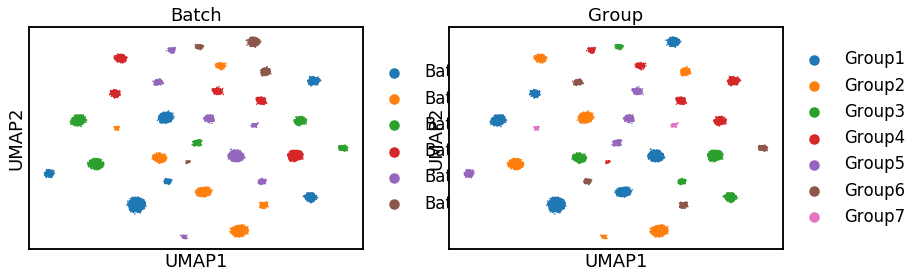

In [42]:
sc.pl.umap(adata, color=['Batch', 'Group'])

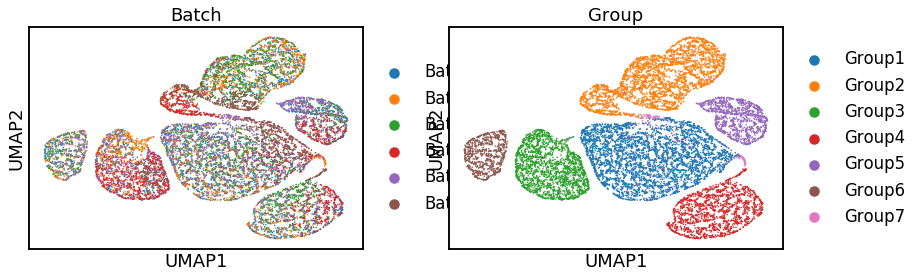

In [27]:
sc.pl.umap(integrated, color=['Batch', 'Group'])

In [114]:
embedding = integrated.obsm['X_emb']

In [63]:
import matplotlib.pyplot as plt

In [138]:
embedding

array([[62.469273,  8.285374],
       [62.528095,  8.212034],
       [64.307106,  9.327104],
       ...,
       [64.84406 , 11.541928],
       [65.67984 ,  8.431269],
       [63.115112,  7.98021 ]], dtype=float32)

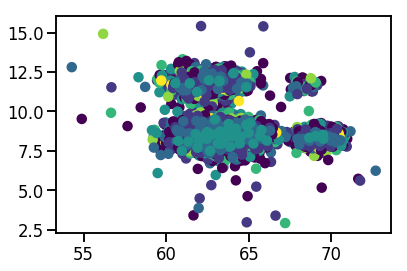

In [140]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(embedding[:, 0], embedding[:, 1], c=integrated.obs.Group.cat.codes)
fig.savefig('embedding_by_cluster.png')